# Evaluate MPNN Performance
Review the models which have been trained and pick one for our application.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import json
import os

## Load in the Models
They are all located in a directory with a `test_summary.json` file

In [2]:
model_dirs = list(map(os.path.dirname, glob(os.path.join('networks', '**', 'test_summary.json'))))
print(f'Found {len(model_dirs)} model directories')

Found 1 model directories


In [3]:
def get_summary(path):
    """Get the summary of a run"""
    
    output = {'path': path}
    
    # Load the config
    with open(os.path.join(path, 'config.json')) as fp:
        output.update(json.load(fp))
        
    # Load in the run summary
    with open(os.path.join(path, 'test_summary.json')) as fp:
        output.update(json.load(fp))
    return output

In [4]:
models = pd.DataFrame(get_summary(p) for p in model_dirs).sort_values('mae')
models.head(5)

,path,atom_features,num_messages,output_layers,batch_size,num_epochs,padded_size,dataset,system,lr_start,runtime,r2_score,spearmanr,kendall_tau,mae,rmse
0,networks/qm9-gpu_b64_n256_cef474,64,8,"[128, 64]",64,256,75,qm9,gpu,0.001,9811.760414,0.999898,0.999935,0.994661,0.002244,0.003858


## Validate the Model
Visualize the results on the hold-out set of 10% of our data

In [5]:
best_model = models.iloc[0]

In [6]:
best_model

path             networks/qm9-gpu_b64_n256_cef474
atom_features                                  64
num_messages                                    8
output_layers                           [128, 64]
batch_size                                     64
num_epochs                                    256
padded_size                                    75
dataset                                       qm9
system                                        gpu
lr_start                                    0.001
runtime                               9811.760414
r2_score                                 0.999898
spearmanr                                0.999935
kendall_tau                              0.994661
mae                                      0.002244
rmse                                     0.003858
Name: 0, dtype: object

In [7]:
test_data = pd.read_csv(os.path.join(best_model['path'], 'test_results.csv'))

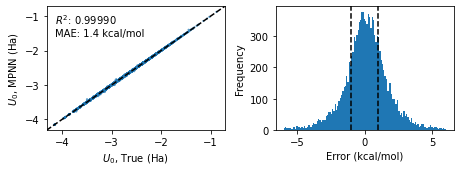

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.5))

errors = (test_data['pred'] - test_data['true']) * 627.50947406  # kcal/mol

ax = axs[0]
ax.scatter(test_data['true'], test_data['pred'], s=5, alpha=0.7, edgecolor='none')
ax.text(0.05, 0.95, f'$R^2$:{best_model["r2_score"]: .5f}\nMAE:{errors.abs().mean(): .1f} kcal/mol', 
       transform=ax.transAxes, va='top', ha='left')

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('$U_0$, True (Ha)')
ax.set_ylabel('$U_0$, MPNN (Ha)')

ax = axs[1]


ax.hist(errors, bins=np.linspace(-6, 6, 128))
ax.text(1, 0.95, f'', 
       transform=ax.transAxes, va='top', ha='right')

ax.set_ylim(ax.get_ylim())
ax.plot([-1, -1], ax.get_ylim(), 'k--')
ax.plot([1, 1], ax.get_ylim(), 'k--')

ax.set_xlabel('Error (kcal/mol)')
ax.set_ylabel('Frequency')
fig.tight_layout()